In [1]:
from utils import *
from plots import *

In [2]:
p = r'/Users/jquinnlee/Desktop/georepca1/georepca1'
os.chdir(p)

In [3]:
animals = ['QLAK-CA1-08', 'QLAK-CA1-30', 'QLAK-CA1-50', 'QLAK-CA1-51', 'QLAK-CA1-56', 'QLAK-CA1-74', 'QLAK-CA1-75']

In [4]:
# get rate map vector fields for all pixels
group_vector_fields, average_vector_fields, std_vector_fields = \
    get_vector_fields_animals(animals, p, stable_simulation=False)


Loading preprocessed data for animal QLAK-CA1-08
Loading preprocessed data for animal QLAK-CA1-30
Loading preprocessed data for animal QLAK-CA1-50
Loading preprocessed data for animal QLAK-CA1-51
Loading preprocessed data for animal QLAK-CA1-56
Loading preprocessed data for animal QLAK-CA1-74
Loading preprocessed data for animal QLAK-CA1-75


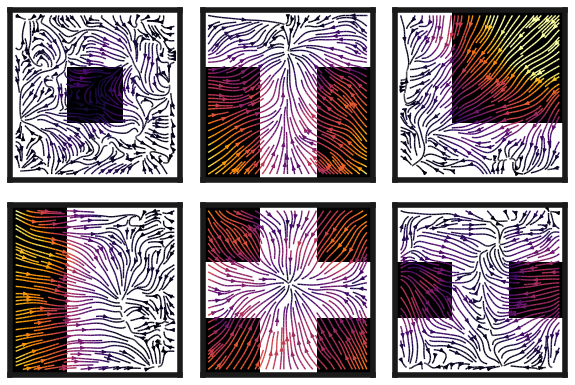

In [5]:
fig = plot_stream_vector_fields(group_vector_fields, average_vector_fields)


In [6]:

feature_type = "BVC2PC"
model_vector_fields, model_average_vector_fields, model_std_vector_fields = \
    get_vector_fields_animals(animals, p, feature_type=feature_type)
fig = plot_stream_vector_fields(model_vector_fields, model_average_vector_fields)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jquinnlee/Desktop/georepca1/georepca1/results/riab/QLAK-CA1-30_BVC2PC_maps'

In [8]:
# # the ordering of each field is the same, following a cannon order (first animal's) of environment shapes
sns.set(style="dark", font_scale=2.)
cannon_order = group_vector_fields[animals[0]]["envs"]
leave_out = animals[0]
for a1, predict_animal in enumerate(animals):
    pvmatrix_average = np.zeros(model_vector_fields[animals[0]]["pvmatrix"].shape[1:])[
                                np.newaxis].repeat(len(animals), axis=0) * np.nan
    for a2, fit_animal in enumerate(animals):
        for e, env in enumerate(cannon_order):
            if fit_animal is not leave_out:
                pvmatrix_average[a2, :, :, e] = np.nanmean(model_vector_fields[fit_animal]["pvmatrix"], axis=0)[:, :, e]
    pvmatrix_average = np.nanmean(pvmatrix_average, axis=0) # average across the included animals
    if a1 == 0:
        fig = plt.figure(figsize=(30, 6))
        for e, env in enumerate(cannon_order):
            ax = plt.subplot(1, cannon_order.shape[0], e+1)
            ax.imshow(pvmatrix_average[:, :, e], cmap="magma")
            if e == 0:
                ax.set_ylabel("Square\npixels", weight="bold")
            ax.set_xlabel(f"\"{env}\"\npixles", weight="bold")
            ax.set_yticks(np.linspace(0, pvmatrix_average[:, :, e].shape[0], 2))
            ax.set_xticks(np.linspace(0, pvmatrix_average[:, :, e].shape[1], 2))
        plt.suptitle(t="Population-vector cross-correlation", weight="bold")
        plt.tight_layout()
        plt.show()
        fig.savefig(os.path.join(p, "Figures", f"{feature_type}_PV_crosscorr_shapes.svg"))
        fig.savefig(os.path.join(p, "Figures", f"{feature_type}_PV_crosscorr_shapes.png"))

# Which correspondence is closest to the brain? Should be the same answer as with the RSA-approach
# feature_type = "PC2SF_0.99900gamma_0.00167alpha"
actual_group_vector_fields, _, _ = get_vector_fields_animals(animals)
actual_pvmatrix_average = np.zeros(actual_group_vector_fields[animals[0]]["pvmatrix"].shape[1:])[
                                   np.newaxis].repeat(len(animals), axis=0) * np.nan
feature_types = ["PC", "PC2SF_0.99900gamma_0.00167alpha", "BVC", "BVC2PC", "BVC2SF_0.99900gamma_0.00167alpha"]
cols = ["Model", "Env", "Fit"]
df_pv_correspondence = pd.DataFrame(data=np.zeros([len(feature_types)*cannon_order.shape[0], len(cols)]),
                                    columns=cols)
c = 0
for feature_type in tqdm(feature_types):
    model_group_vector_fields, _, _ = get_vector_fields_animals(animals, feature_type=feature_type)
    model_pvmatrix_average = np.zeros_like(actual_pvmatrix_average) * np.nan
    for a, animal in enumerate(animals):
        for e, env in enumerate(cannon_order):
            # average result for environment across sequences, for target animal, then add to group result
            actual_pvmatrix_average[a, :, :, e] = np.nanmean(actual_group_vector_fields[animal]["pvmatrix"], axis=0)[:, :, e]
            model_pvmatrix_average[a, :, :, e] = np.nanmean(model_group_vector_fields[animal]["pvmatrix"], axis=0)[:, :, e]
    actual_average_vector_fields = np.nanmean(actual_pvmatrix_average, axis=0)
    model_average_vector_fields = np.nanmean(model_pvmatrix_average, axis=0)

    for e, env in enumerate(cannon_order):
        mask = ~np.isnan(actual_average_vector_fields[:, :, e])
        fit = kendalltau(actual_average_vector_fields[:, :, e][mask],
                              model_average_vector_fields[:, :, e][mask])[0]
        df_pv_correspondence.iloc[c] = np.hstack((feature_type, env, fit))
        c+=1
df_pv_correspondence["Fit"] = df_pv_correspondence["Fit"].astype(float)

feature_names = ["PC", "PC2SF", "BVC", "BVC2PC", "BVC2SF"]

plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.barplot(data=df_pv_correspondence, x="Model", y="Fit", errorbar="se", width=0.5, linewidth=4., errwidth=4.,
            edgecolor="k", color="gray", errcolor="k", saturation=1.)
ax.set_xticklabels(feature_names, rotation=90, weight="bold")
ax.set_ylabel("PV Correspondence (Tau)", weight="bold")
ax.set_xlabel("")
plt.setp(ax.spines.values(), color="k", linewidth=4.)
plt.tight_layout()
plt.show()

TypeError: get_vector_fields_animals() missing 1 required positional argument: 'p'

In [9]:

def plot_spatial_correspondence(feature_type=None, vmin=-.1, vmax=1.):
    if feature_type is None:
        pv_matrix = joblib.load(os.path.join(p, "results", "pv_corr_pixelwise"))
    else:
        pv_matrix = joblib.load(os.path.join(p, "results", "riab", f"pv_corr_pixelwise_{feature_type}"))

    n_bins = int(np.sqrt(pv_matrix[0, 0].shape[0]))
    n_cols = (np.arange(1, n_bins - 1, 6).shape[0] ** 2) + 1
    n_rows = pv_matrix.shape[1]

    for e1, env1 in tqdm(enumerate(cannon_order), position=0, leave=True, desc="Plotting spatial correspondence"):
        print(env1)
        fig = plt.figure(figsize=(20, 20))
        count = 1
        for y in np.arange(1, n_bins - 1, 6):
            for x in np.arange(1, n_bins - 1, 6):
                for e2, env2 in enumerate(cannon_order):
                    ax = plt.subplot(n_cols, n_rows, count)
                    count += 1
                    transform = pv_matrix[e1, e2]
                    nan_mask1 = np.all(np.isnan(transform), axis=1).reshape(n_bins, n_bins)  # mask for env1
                    nan_mask2 = np.all(np.isnan(transform), axis=0).reshape(n_bins, n_bins)  # mask for env2

                    if ~nan_mask1[x, y]:
                        position_map = np.zeros([n_bins, n_bins])
                        position_map[x, y] = 1.
                        prediction = (np.nan_to_num(position_map).ravel()[np.newaxis] @
                                      np.nan_to_num(transform)).squeeze().reshape(n_bins, n_bins)
                        prediction[nan_mask2] = np.nan
                        prediction = np.nanmean(np.dstack((gaussian_filter(np.nan_to_num(prediction, 0),
                                                                           1),
                                                           gaussian_filter(np.nan_to_num(prediction, 1),
                                                                           1))), -1)
                        prediction[nan_mask2] = np.nan
                        max_map = prediction == np.nanmax(np.nan_to_num(prediction))
                        x_hat, y_hat = np.where(max_map)
                        ax.scatter(x_hat, y_hat, alpha=1., zorder=1, c="red", marker="s", s=2e2, linewidth=None,
                                    edgecolor="white")
                        ax.imshow(prediction.T, alpha=1., zorder=0, cmap="viridis", vmax=vmax, vmin=vmin)

                    ax.set_yticks([])
                    ax.set_xticks([])
                    plt.setp(ax.spines.values(), linewidth=4., color="k")

        plt.tight_layout()
        plt.show()

        if glob(os.path.join(p, "Figures", "pv_correspondence_plots")) == []:
            os.mkdir(os.path.join(p, "Figures", "pv_correspondence_plots"))
        if feature_type is None:
            fig.savefig(os.path.join(p, "Figures", "pv_correspondence_plots", f"position_pvcorr_{env1}.png"),
                        dpi=300)
            fig.savefig(os.path.join(p, "Figures", "pv_correspondence_plots", f"position_pvcorr_{env1}.svg"))
        else:
            fig.savefig(os.path.join(p, "Figures", "pv_correspondence_plots",
                                     f"position_pvcorr_{env1}_{feature_type}.png"),
                        dpi=300)
            fig.savefig(os.path.join(p, "Figures", "pv_correspondence_plots",
                                     f"position_pvcorr_{env1}_{feature_type}.svg"))
        plt.close()


plot_spatial_correspondence(None)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jquinnlee/Desktop/georepca1/georepca1/results/pv_corr_pixelwise'

In [16]:
sr_gamma=0.999
sr_alpha=(50./30.)*10**(-3)
feature_types = ["PC", "GC2PC_th", f"PC2SF_{sr_gamma:.5f}gamma_{sr_alpha:.5f}alpha", "bt_GC2PC_th", "BVC2PC", f"BVC2SF_{sr_gamma:.5f}gamma_{sr_alpha:.5f}alpha"]
feature_names = ["PC", "GC2PC", "PC2SF", "bt-GC2PC", "BVC2PC", "BVC2SF"]


6it [00:06,  1.11s/it]


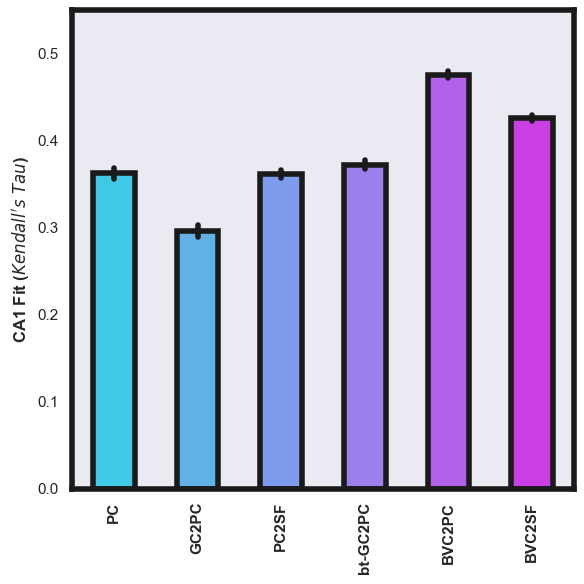

In [17]:
pv_matrix_sequences = np.nanmean(joblib.load(os.path.join(p, "results", "pv_corr_pixelwise_animals_sequences")), axis=0)

cols = ["Model", "EnvA", "EnvB", "Sequence", "Fit"]
model_pv_fit_df = pd.DataFrame(data=np.zeros([np.prod(pv_matrix_sequences.shape[:3]) * len(feature_types),
                                              len(cols)]) * np.nan, columns=cols)
count = 0
for f, feature_type in tqdm(enumerate(feature_types)):
    pv_matrix_model = joblib.load(os.path.join(p, "results", f"pv_corr_pixelwise_{feature_type}"))
    for s in range(pv_matrix_sequences.shape[0]):
        for e1, env1 in enumerate(cannon_order):
            for e2, env2 in enumerate(cannon_order):
                true_pv = pv_matrix_sequences[s, e1, e2]
                model_pv = pv_matrix_model[e1, e2]
                nan_mask = ~np.isnan(true_pv + model_pv)
                fit = kendalltau(true_pv[nan_mask], model_pv[nan_mask])[0]
                model_pv_fit_df.iloc[count] = np.hstack((feature_names[f], env1, env2, s, fit))
                count += 1
model_pv_fit_df.iloc[:, 3:] = model_pv_fit_df.iloc[:, 3:].astype(float)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.barplot(data=model_pv_fit_df, x="Model", y="Fit", errorbar="se", palette="cool",
            width=.5, edgecolor="k", linewidth=4., errwidth=4., errcolor="k")
ax.set_xticklabels(feature_names, rotation=90, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("CA1 Fit ($Kendall's\ Tau$)", weight="bold")
ax.set_ylim([0., .55])
plt.setp(ax.spines.values(), linewidth=4., color="k")
plt.tight_layout()
plt.show()